In [1]:
import numpy as np
import pandas as pd
import spacy
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
nlp=spacy.load('en_core_web_sm')

In [23]:
df=pd.read_csv(r'C:\Users\MUKU\Desktop\Python\NLP\nlp datasets\all_opinions.csv')

In [4]:
# Checking for nulls, I will drop the columns that have null values if they are not needed.
df.isnull().sum()

author_name                   0
category                      0
per_curiam                    0
case_name                     0
date_filed                    0
federal_cite_one              2
absolute_url                  0
cluster                       0
year_filed                    0
scdb_id                    1252
scdb_decision_direction    1256
scdb_votes_majority        1252
scdb_votes_minority        1252
text                          0
dtype: int64

In [25]:
# First peek at the data frame
df.head()

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
0,justice roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...
1,justice thomas,concurring,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...
2,justice breyer,dissenting,False,McCutcheon v. Federal Election Comm'n,2014-04-02,134 S. Ct. 1434,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U..."
3,justice taney,majority,False,Ex Parte Crenshaw,1841-02-18,40 U.S. 119,https://www.courtlistener.com/opinion/86166/ex...,https://www.courtlistener.com/api/rest/v3/clus...,1841,1841-005,2.0,9.0,0.0,This case was brought here by an appeal from t...
4,justice pitney,majority,False,Richards v. Washington Terminal Co.,1914-05-04,233 U.S. 546,https://www.courtlistener.com/opinion/98178/ri...,https://www.courtlistener.com/api/rest/v3/clus...,1914,1913-149,1.0,8.0,1.0,"Plaintiff in error, who was plaintiff below, c..."


# Exploratory Data Analysis

#### What do we want to find from our data?

- Distribution of the type of opinion for the top 15 justice.
- 

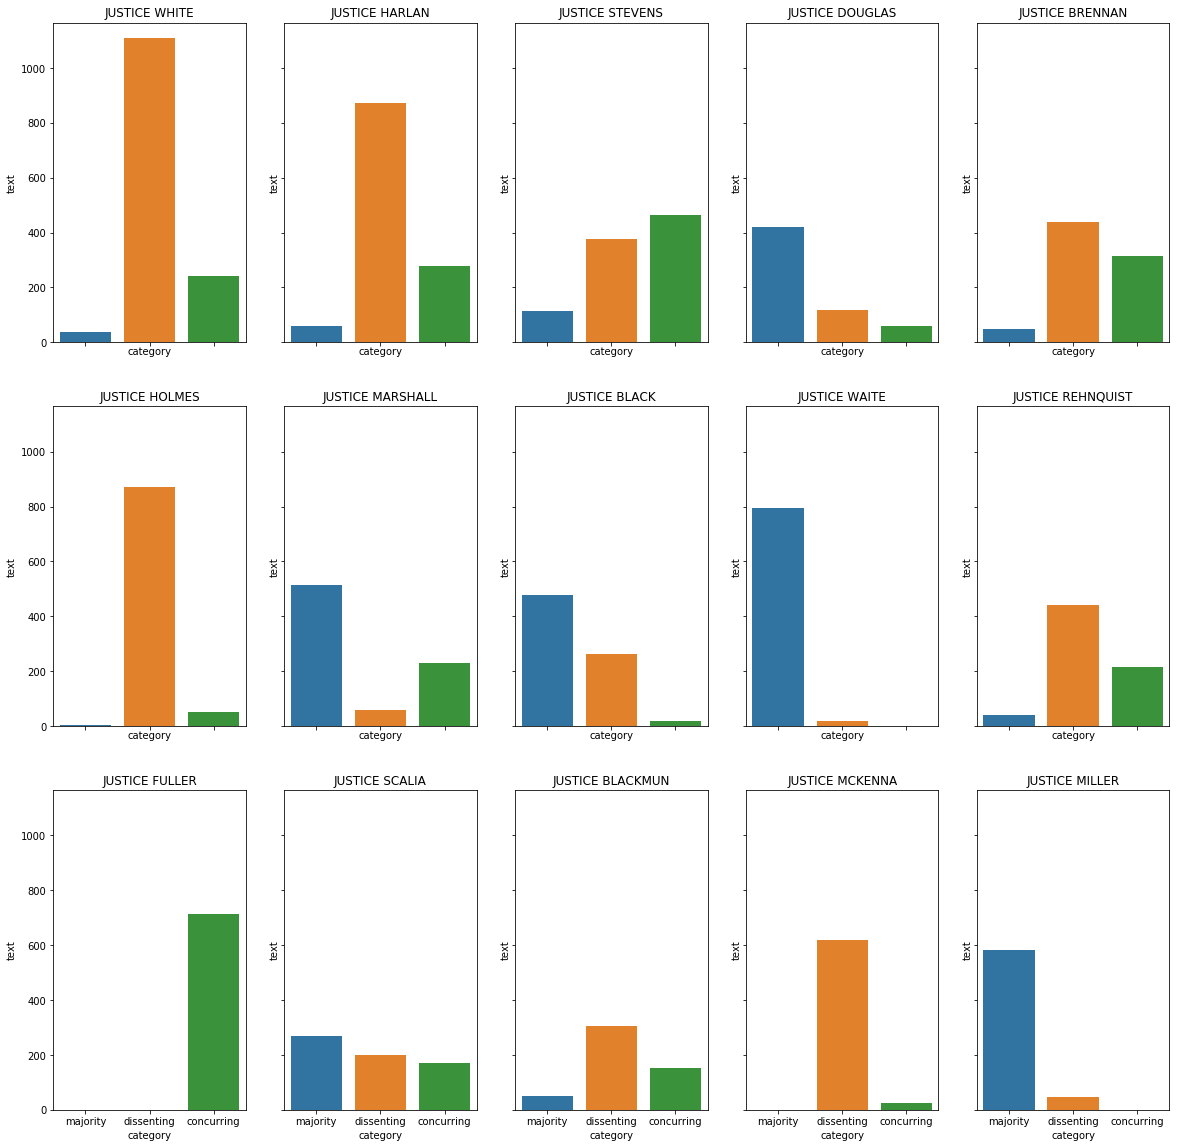

In [6]:
# Selecting only the columns that i will be using for my analysis
df=df[['author_name','category','per_curiam','case_name','date_filed','text']]

# Selecting top 15 justice based of opinions written
top_15=df['author_name'].value_counts()[1:16].index

# Grouping them based on name and category
justice_df=df[df['author_name'].isin(top_15)].groupby(['author_name','category']).count().sort_values('author_name',ascending=False)['text']

# Using Seaborn to visualize opinions of the top 15 judges.
justice_categories=[justice_df.loc[justice].index for justice in top_15]
justice_values=[justice_df.loc[justice] for justice in top_15]
f, axes = plt.subplots(3,5,figsize=(20,20),sharex=True,sharey=True,squeeze=False)

# For loop to plot all the opinions of the top 15 Justice
for ax,x,y,names in zip(axes.flatten(),justice_categories,justice_values,top_15):
    plot=sns.barplot(x,y,orient='v',ax=ax)
    plot.set_title(names.upper())
    plt.rcParams.update({'font.size': 10})

# Insights:
- Justice Fuller mostly made opinions that concurred

- Most of the Justices tend to write dissenting opinions

- Justice Waite tends to go with the majority

## Cleaning and preparing the data

In [7]:
def clean_data(text_):
    """
    A function that does the following to the text data:
    1) lower the text
    2) Removes entities, punctuation, extra spaces, stop words.
    3) Returns the lemmatized version of the word
    """
    doc=nlp(text_.lower())
    doc_ents=[word.text for word in doc.ents]
    doc=[token for token in doc if token.is_space==False and token.is_punct==False and token.is_stop==False]
    return re.sub('[\d+]','',' '.join([token.lemma_ for token in doc if token.text not in doc_ents]))

In [8]:
# Cleaning the text data
df['text']=df['text'].apply(lambda x: clean_data(x))

In [9]:
# Converting documents into vectors and counting the words
CV=CountVectorizer(max_df=.95,min_df=2)
dtm=CV.fit_transform(df['text'])

In [10]:
# Using the converted and counted matrix of documents pulling out the most common words from the entire corpus
list_of_numbers=np.asarray(dtm.sum(axis=0)).ravel().tolist()
list_of_words=CV.get_feature_names()
dict_of_words_and_numbers=dict(zip(list_of_words,list_of_numbers))
list_of_tuples=sorted(dict_of_words_and_numbers.items(),key=lambda x: x[1])
list_of_extra_stop_words=[ele[0] for ele in list_of_tuples[-20:]]
for ele in list_of_extra_stop_words:
    STOP_WORDS.add(ele)
    nlp.vocab[ele].is_stop=True

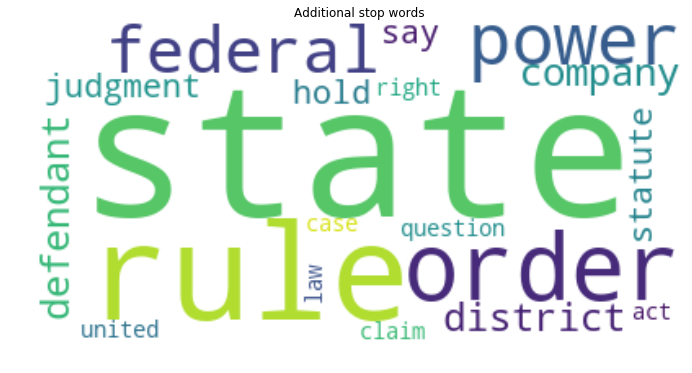

In [11]:
# Showcasing the top 50 words in a word cloud, we will be removing these from the list.
text=' '.join(list_of_extra_stop_words)
image=WordCloud(background_color='white').generate(text)
fig=plt.figure(figsize=(12,6))
plt.imshow(image,interpolation='bilinear')
plt.title('Additional stop words')
print('\n')
plt.axis('off')
plt.show()
plt.rcParams.update({'font.size': 22})

In [20]:
# Re-running the Count vectorizer so as to accumulate the matrix with
CV=CountVectorizer(max_df=.95,min_df=2)
dtm=CV.fit_transform(df['text'])

In [13]:
# Removing the extra stop words from the data
df['text']=df['text'].apply(lambda x: clean_data(x))

In [15]:
df.to_pickle('cleaned_data.pkl')

In [18]:
df=df.sample(1000)

## Latent Dirichlet Alocation

In [21]:
# initializing LDA and setting the number of clusters to 5
LDA= LatentDirichletAllocation(n_components=5,random_state=42)

# LDA fit and transform
LDA_transformed=LDA.fit_transform(dtm)

# Gathering the top 15 words in each cluster We use these words to define our categories names
list_of_topic_words=[[CV.get_feature_names()[index] for index in topic.argsort()[-15:]] for i,topic in enumerate(LDA.components_)]


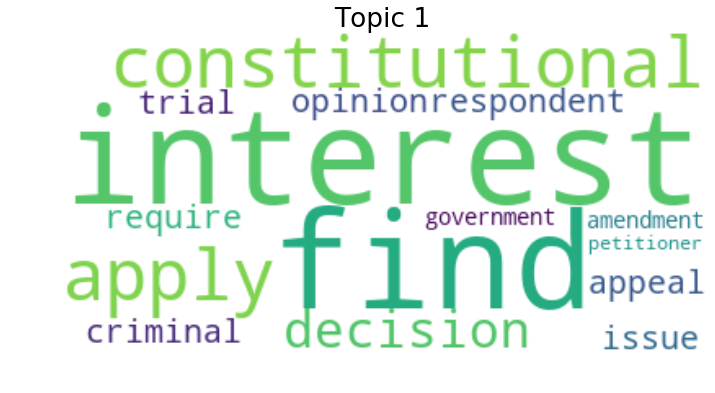

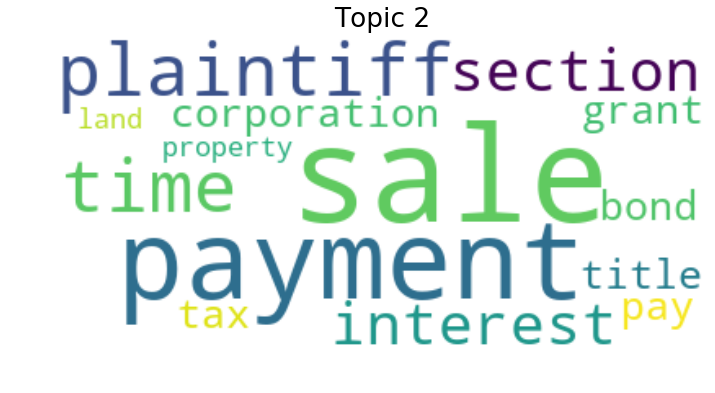

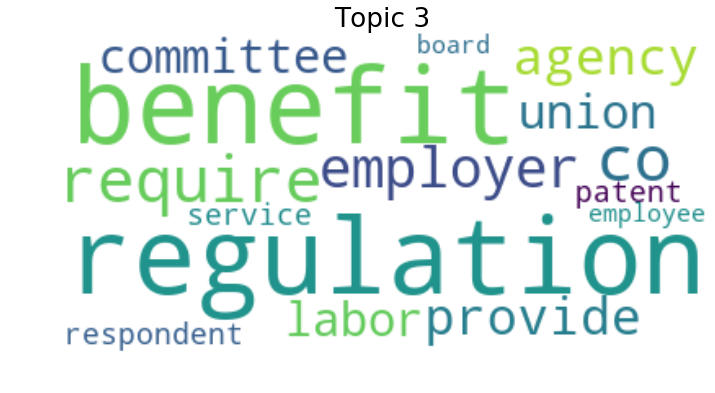

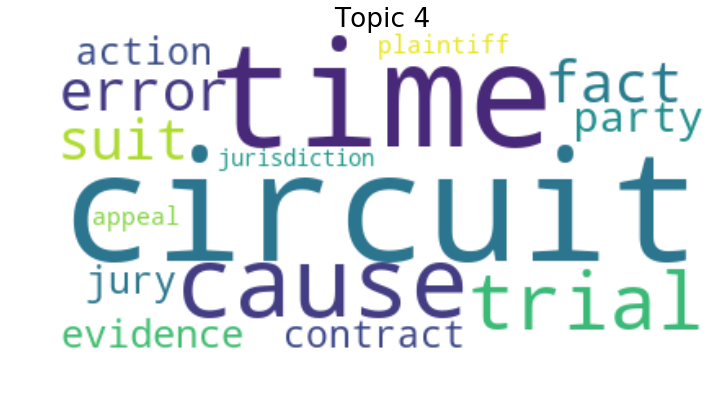

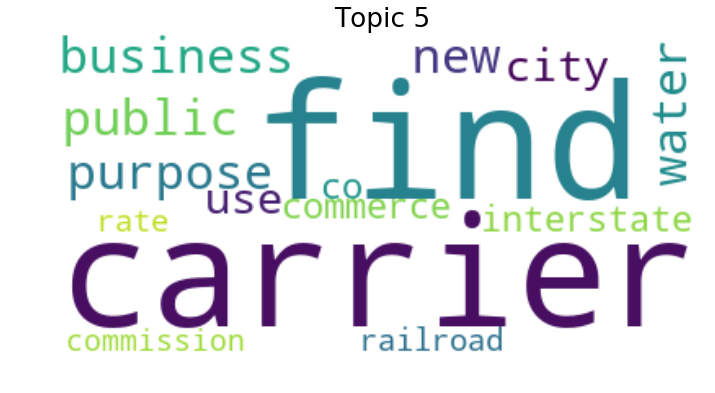

In [22]:
# Converting matrcies into lists and the pulling out the top 15 words from each cluster of words.
# Each cluster represents a topic.

list_of_topic_words1=[' '.join(cluster) for cluster in list_of_topic_words]



# Taking the top 15 words and plotting them into word clouds

wc = [WordCloud(background_color="white").generate(topic) for topic in list_of_topic_words1]
for index,image in enumerate(wc):
    fig=plt.figure(figsize=(12,6))
    plt.imshow(image,interpolation='bilinear')
    plt.title(f'Topic {index+1}')
    plt.axis('off')
    plt.show()
    plt.rcParams.update({'font.size': 22})
    print('\n')
    print('\n')
    print('\n')

# Non-Negative Matrix Factorization

In [ ]:
# initializing Term frequency - Inverse document frequency
tfidf=TfidfVectorizer(max_df=0.95,min_df=2)

# Converts the words into a vectors and populates a sparse matrix and gets the tfidf for each word.
dtm1=tfidf.fit_transform(df['text'])

In [ ]:
# Initializing Non-Negative Matrix Factorization Model
# Taking n_components = 5
nmf_model=NMF(n_components=5,random_state=42)

#Segregates the words into different topics
nmf_model.fit(dtm1)

In [ ]:
# Converting matrcies into lists and the pulling out the top 15 words from each cluster of words.
# Each cluster represents a topic.

list_of_sorted_words_NMF=[topic.argsort()[-15:] for topic in nmf_model.components_]
list_of_sorted_words_NMF=[[tfidf.get_feature_names()[index] for index in topic] for topic in list_of_sorted_words_NMF]
wc_NMF=[WordCloud(background_color='white').generate(' '.join(topic_words)) for topic_words in list_of_sorted_words_NMF]

# Taking the top 15 words and plotting them into word clouds

for index,wc in enumerate(wc_NMF):
    fig=plt.figure(figsize=(12,6))
    plt.imshow(wc,interpolation='bilinear')
    plt.title(f'Topic {index+1}')
    plt.axis('off')
    plt.show()
    plt.rcParams.update({'font.size': 22})
    print('\n')
    print('\n')
    print('\n')